Loading and combining train and validation datasets...
Rounding threshold column...
Combined data shape: (1111, 18)

Transforming sequence data into tabular format for Random Forest...
Tabular data shape for training: (1089, 9)
Sample of tabular data:
   model_id  threshold_val         flops  non_zero_params  \
0         0            0.1  5.427159e+09         65041647   
1         0            0.2  5.271010e+09         63170279   
2         0            0.3  5.121331e+09         61376458   
3         0            0.4  4.979394e+09         59675410   
4         0            0.5  4.845886e+09         58075397   

   params_reduction_pct  flops_reduction_pct  acc_0_input  \
0              2.857685             2.857685        0.994   
1              5.652648             5.652648        0.994   
2              8.331792             8.331792        0.994   
3             10.872375            10.872375        0.994   
4             13.262059            13.262059        0.994   

   lagged_accu

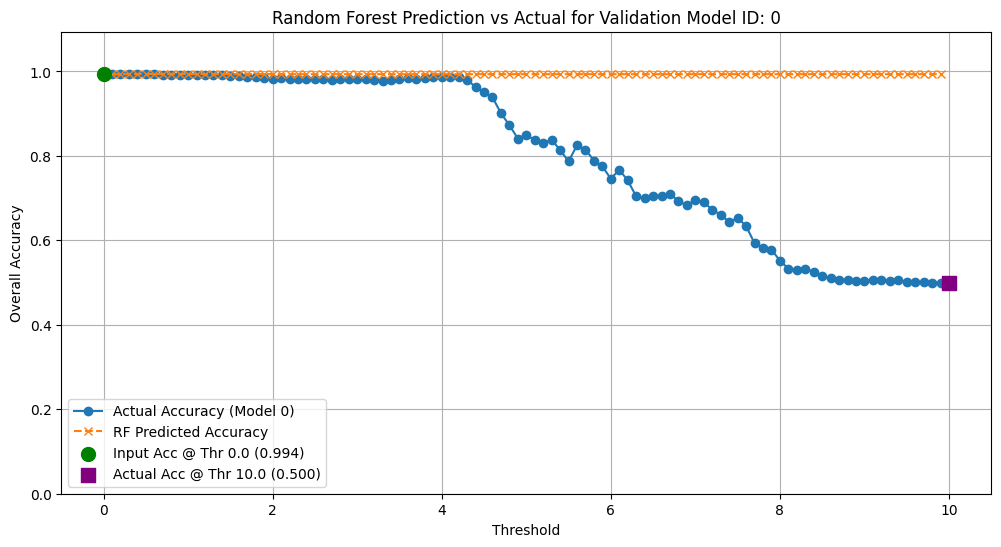


Random Forest script finished.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # For splitting the tabular data
from sklearn.preprocessing import StandardScaler # Standard scaling is often good for RF
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- Configuration ---
DATASET_PATH = Path("data_split")
TARGET_COL = 'overall_accuracy'
INTERMEDIATE_THRESHOLDS = np.round(np.arange(0.1, 10.0, 0.1), 1)
RANDOM_STATE = 42

# --- 1. Load and Combine Train and Validation Datasets ---
print("Loading and combining train and validation datasets...")
try:
    train_df_raw = pd.read_csv(DATASET_PATH / "train_dataset.csv")
    validation_df_raw = pd.read_csv(DATASET_PATH / "validation_dataset.csv")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Make sure train/validation CSVs exist in '{DATASET_PATH}'.")
    exit()

combined_df_raw = pd.concat([train_df_raw, validation_df_raw], ignore_index=True)
print("Rounding threshold column...")
combined_df = combined_df_raw.copy()
combined_df['threshold'] = combined_df['threshold'].round(1)
print(f"Combined data shape: {combined_df.shape}")

# --- 2. Transform Sequence Data into Tabular Format for Training ---
print("\nTransforming sequence data into tabular format for Random Forest...")
tabular_data_list = []

for model_id, group in combined_df.groupby('model_id'):
    group = group.sort_values(by='threshold').reset_index(drop=True)
    
    acc_at_0_series = group[group['threshold'] == 0.0][TARGET_COL]
    # acc_at_10_series = group[group['threshold'] == 10.0][TARGET_COL] # For acc_10 feature if used

    if acc_at_0_series.empty: # or acc_at_10_series.empty if using acc_10
        print(f"Skipping model_id {model_id} for tabular transformation: missing boundary data.")
        continue
        
    acc_0_val = acc_at_0_series.iloc[0]
    # acc_10_val = acc_at_10_series.iloc[0] # If using acc_10

    # Prepare lagged accuracy (teacher forcing for training)
    # For the first intermediate step (0.1), the lagged acc is acc_0
    # For subsequent steps, it's the actual accuracy of the previous step
    
    # Get all actual accuracies for this model_id to easily create lagged feature
    all_accuracies_this_model = group.set_index('threshold')[TARGET_COL]

    for t_intermediate in INTERMEDIATE_THRESHOLDS:
        current_step_data = group[group['threshold'] == t_intermediate]
        
        if current_step_data.empty:
            # print(f"Warning: Missing data for model_id {model_id} at threshold {t_intermediate}.")
            continue # Skip this specific threshold if data is missing

        # Determine lagged threshold
        if t_intermediate == 0.1:
            lagged_t = 0.0
        else:
            lagged_t = np.round(t_intermediate - 0.1, 1)
        
        try:
            lagged_acc = all_accuracies_this_model.loc[lagged_t]
        except KeyError:
            # This might happen if 0.0 is missing or if a previous intermediate step was skipped
            # A robust way would be to ensure all_accuracies_this_model has 0.0
            # For simplicity, if direct lookup fails for 0.0, use acc_0_val
            if lagged_t == 0.0:
                 lagged_acc = acc_0_val
            else:
                # print(f"Warning: Could not find lagged accuracy for model_id {model_id} at threshold {t_intermediate} (lagged_t={lagged_t}). Skipping.")
                continue


        features = {
            'model_id': model_id, # Keep for grouping during prediction if needed
            'threshold_val': t_intermediate, # The threshold itself as a feature
            'flops': current_step_data['flops'].iloc[0],
            'non_zero_params': current_step_data['non_zero_params'].iloc[0],
            'params_reduction_pct': current_step_data['params_reduction_pct'].iloc[0],
            'flops_reduction_pct': current_step_data['flops_reduction_pct'].iloc[0],
            'acc_0_input': acc_0_val,
            # 'acc_10_input': acc_10_val, # Uncomment if using acc_10
            'lagged_accuracy_input': lagged_acc,
            TARGET_COL: current_step_data[TARGET_COL].iloc[0] # The target
        }
        tabular_data_list.append(features)

if not tabular_data_list:
    print("No data transformed into tabular format. Exiting.")
    exit()

tabular_df = pd.DataFrame(tabular_data_list)
print(f"Tabular data shape for training: {tabular_df.shape}")
print("Sample of tabular data:")
print(tabular_df.head())

# --- 3. Prepare Data for Scikit-learn Model ---
# We will use a portion of combined_df for training the RF, and another for validation (auto-regressive)
# To do this properly, we should split by model_id *before* creating tabular_df
# Or, use the existing train_df, validation_df to create tabular_train_df and tabular_val_df

# Let's re-do tabular transformation on pre-split train_df for training RF
# And then use validation_df for auto-regressive prediction and evaluation
print("\nRe-transforming pre-split train_df to tabular for RF training...")
train_tabular_list = []
for model_id, group in train_df_raw.groupby('model_id'): # Use train_df_raw and round later
    group = group.copy()
    group['threshold'] = group['threshold'].round(1)
    group = group.sort_values(by='threshold').reset_index(drop=True)
    acc_at_0_series = group[group['threshold'] == 0.0][TARGET_COL]
    if acc_at_0_series.empty: continue
    acc_0_val = acc_at_0_series.iloc[0]
    all_accuracies_this_model = group.set_index('threshold')[TARGET_COL]
    for t_intermediate in INTERMEDIATE_THRESHOLDS:
        current_step_data = group[group['threshold'] == t_intermediate]
        if current_step_data.empty: continue
        lagged_t = 0.0 if t_intermediate == 0.1 else np.round(t_intermediate - 0.1, 1)
        try: lagged_acc = all_accuracies_this_model.loc[lagged_t]
        except KeyError: lagged_acc = acc_0_val if lagged_t == 0.0 else np.nan # mark as nan if missing
        if pd.isna(lagged_acc) : continue # skip if lagged acc is missing

        features = {
            'threshold_val': t_intermediate,
            'flops': current_step_data['flops'].iloc[0],
            'non_zero_params': current_step_data['non_zero_params'].iloc[0],
            'params_reduction_pct': current_step_data['params_reduction_pct'].iloc[0],
            'flops_reduction_pct': current_step_data['flops_reduction_pct'].iloc[0],
            'acc_0_input': acc_0_val,
            'lagged_accuracy_input': lagged_acc,
            TARGET_COL: current_step_data[TARGET_COL].iloc[0]
        }
        train_tabular_list.append(features)
train_tabular_df = pd.DataFrame(train_tabular_list)

if train_tabular_df.empty:
    print("Train tabular data is empty. Cannot proceed.")
    exit()

feature_names = ['threshold_val', 'flops', 'non_zero_params', 'params_reduction_pct', 
                 'flops_reduction_pct', 'acc_0_input', 'lagged_accuracy_input']
X_train_rf = train_tabular_df[feature_names]
y_train_rf = train_tabular_df[TARGET_COL]

# Scaling features
scaler_rf = StandardScaler()
X_train_rf_scaled = scaler_rf.fit_transform(X_train_rf)

# --- 4. Train Random Forest Regressor ---
print("\nTraining Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, max_depth=10, min_samples_split=10, min_samples_leaf=5)
rf_model.fit(X_train_rf_scaled, y_train_rf)

print("Random Forest training complete.")
# Feature importances (optional)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)

# --- 5. Auto-Regressive Prediction on Validation Set ---
print("\nPerforming auto-regressive prediction on validation set using Random Forest...")
all_rf_predictions_val = {} # {model_id: [predictions]}
all_rf_actuals_val = {}   # {model_id: [actuals]}

validation_df_rounded = validation_df_raw.copy() # Use original val df
validation_df_rounded['threshold'] = validation_df_rounded['threshold'].round(1)

for model_id, group in validation_df_rounded.groupby('model_id'):
    group = group.sort_values(by='threshold').reset_index(drop=True)
    
    acc_at_0_series = group[group['threshold'] == 0.0][TARGET_COL]
    # acc_at_10_series = group[group['threshold'] == 10.0][TARGET_COL] # For plot

    if acc_at_0_series.empty: continue # or acc_at_10_series.empty if using acc_10 feature
        
    acc_0_val = acc_at_0_series.iloc[0]
    # acc_10_val = acc_at_10_series.iloc[0] # If using acc_10 feature

    current_model_predictions = []
    current_model_actuals = []
    last_predicted_acc = acc_0_val # Initialize for the first step

    # Get actual curve for comparison
    actual_intermediate_curve = group[group['threshold'].isin(INTERMEDIATE_THRESHOLDS)].sort_values(by='threshold')[TARGET_COL].values
    
    if len(actual_intermediate_curve) != len(INTERMEDIATE_THRESHOLDS):
        print(f"Warning: Model ID {model_id} in validation set does not have all {len(INTERMEDIATE_THRESHOLDS)} intermediate points. Has {len(actual_intermediate_curve)}. Skipping for detailed eval.")
        # Storing only what is available if you want partial eval
        # For now, let's skip if not complete for simplicity in MAE calculation of full curves
        continue


    for t_intermediate in INTERMEDIATE_THRESHOLDS:
        current_step_data_val = group[group['threshold'] == t_intermediate]
        
        if current_step_data_val.empty:
            # This ideally shouldn't happen if the check above passed for len(actual_intermediate_curve)
            print(f"Critical: Missing data for model_id {model_id} at threshold {t_intermediate} during validation prediction. Setting prediction to last known.")
            current_model_predictions.append(last_predicted_acc) # Fallback
            continue

        features_for_pred = pd.DataFrame([{
            'threshold_val': t_intermediate,
            'flops': current_step_data_val['flops'].iloc[0],
            'non_zero_params': current_step_data_val['non_zero_params'].iloc[0],
            'params_reduction_pct': current_step_data_val['params_reduction_pct'].iloc[0],
            'flops_reduction_pct': current_step_data_val['flops_reduction_pct'].iloc[0],
            'acc_0_input': acc_0_val,
            # 'acc_10_input': acc_10_val, # If using acc_10
            'lagged_accuracy_input': last_predicted_acc
        }])[feature_names] # Ensure correct column order

        features_for_pred_scaled = scaler_rf.transform(features_for_pred)
        prediction = rf_model.predict(features_for_pred_scaled)[0]
        prediction = np.clip(prediction, 0, 1) # Clip prediction
        
        current_model_predictions.append(prediction)
        last_predicted_acc = prediction # Update for next step

    all_rf_predictions_val[model_id] = np.array(current_model_predictions)
    all_rf_actuals_val[model_id] = actual_intermediate_curve # Stored earlier

# --- 6. Evaluate Random Forest ---
if not all_rf_predictions_val:
    print("No predictions made for validation set with Random Forest. Cannot evaluate.")
else:
    all_preds_flat_rf = np.concatenate([p for p in all_rf_predictions_val.values()])
    all_actuals_flat_rf = np.concatenate([a for a in all_rf_actuals_val.values()])
    
    rf_mae_val = mean_absolute_error(all_actuals_flat_rf, all_preds_flat_rf)
    print(f"\nRandom Forest MAE on Validation Set (Auto-Regressive): {rf_mae_val:.4f}")

    # --- 7. Plot one example chart ---
    plot_model_ids_rf = list(all_rf_predictions_val.keys())
    if plot_model_ids_rf:
        plot_model_id_rf = plot_model_ids_rf[0]
        print(f"\nPlotting RF results for model_id: {plot_model_id_rf}")

        plt.figure(figsize=(12, 6))
        plt.plot(INTERMEDIATE_THRESHOLDS, all_rf_actuals_val[plot_model_id_rf], label=f'Actual Accuracy (Model {plot_model_id_rf})', marker='o', linestyle='-')
        plt.plot(INTERMEDIATE_THRESHOLDS, all_rf_predictions_val[plot_model_id_rf], label=f'RF Predicted Accuracy', marker='x', linestyle='--')

        # Get original acc_0 and acc_10 for this model for plotting
        model_data_for_plot_rf = validation_df_rounded[validation_df_rounded['model_id'] == plot_model_id_rf]
        acc0_plot_val_rf = model_data_for_plot_rf[model_data_for_plot_rf['threshold']==0.0][TARGET_COL].iloc[0]
        acc10_series_rf = model_data_for_plot_rf[model_data_for_plot_rf['threshold']==10.0][TARGET_COL]
        acc10_plot_val_rf = acc10_series_rf.iloc[0] if not acc10_series_rf.empty else np.nan


        plt.scatter([0.0], [acc0_plot_val_rf], color='green', s=100, zorder=5, label=f'Input Acc @ Thr 0.0 ({acc0_plot_val_rf:.3f})')
        if not pd.isna(acc10_plot_val_rf):
            plt.scatter([10.0], [acc10_plot_val_rf], color='purple', marker='s', s=100, zorder=5, label=f'Actual Acc @ Thr 10.0 ({acc10_plot_val_rf:.3f})')
        
        plt.title(f"Random Forest Prediction vs Actual for Validation Model ID: {plot_model_id_rf}")
        plt.xlabel("Threshold")
        plt.ylabel("Overall Accuracy")
        plt.legend()
        plt.grid(True)
        plt.ylim(min(0, np.min(all_rf_actuals_val[plot_model_id_rf])-0.1), max(1, np.max(all_rf_actuals_val[plot_model_id_rf])+0.1))
        plt.show()

print("\nRandom Forest script finished.")